In [1]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *

config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

Using TensorFlow backend.


In [2]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']

with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)



W0724 14:13:09.039803 4619298240 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 14:13:09.055059 4619298240 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 14:13:09.057913 4619298240 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 14:13:09.428028 4619298240 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name 

In [3]:
look_back = config['MODEL']['look_back']
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])

In [4]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)

Grabbing WebIDs ...
WebID collection complete!
14:13:09: Sending API request... Chunk 1 of 1
14:13:09: Response recieved for 2 tags! (0.21)


In [5]:
df = create_standard_multivariable_df(df)

Generated: 49 columns


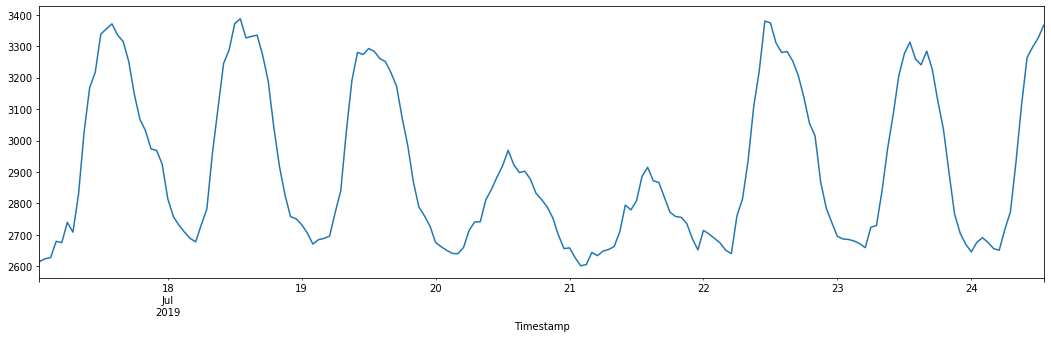

In [6]:
df[point_name].plot(figsize = (18,5))

In [7]:
y = df[point_name]
X = df.drop(columns=point_name)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))

X_test = scaler.fit_transform(X)
y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))


In [9]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [10]:
prediction = model.predict(X_test)

In [11]:
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [12]:
prediction = prediction 

In [13]:
index = df.index

<Figure size 1296x144 with 0 Axes>

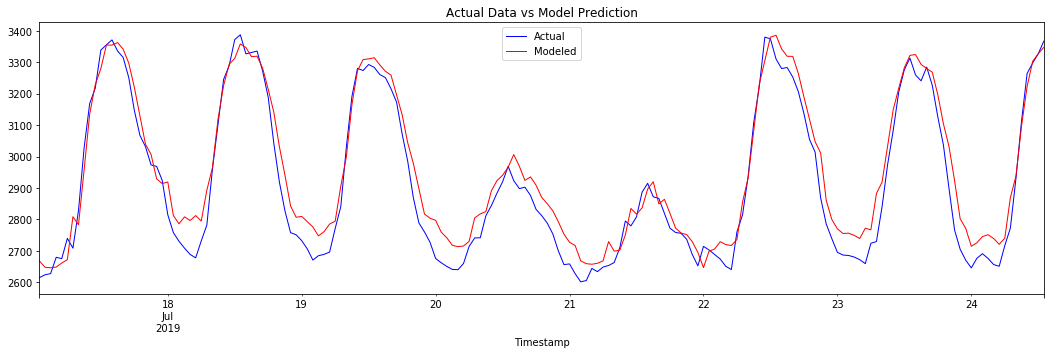

In [14]:
plt.figure(figsize=(18,2))
result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)

result.plot(figsize=(18,5),
                         title="Actual Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])

In [15]:
#result.set_index(index, inplace = True)

In [16]:
result.eval('Difference = (Actual - Modeled)/ Modeled * 100', inplace=True)

#result["Difference"] = result['Actual'] - result['Modeled']
result["Difference"] = result['Difference'].abs().round(decimals = 2)

In [17]:
result.head()

,Actual,Modeled,Difference
Timestamp,,,
2019-07-17 01:00:00,2614.991353,2667.882568,1.98
2019-07-17 02:00:00,2623.946960,2647.858398,0.90
2019-07-17 03:00:00,2627.607707,2646.142334,0.70
2019-07-17 04:00:00,2679.489187,2648.427002,1.17
2019-07-17 05:00:00,2675.266215,2661.536377,0.52


In [18]:
actual = result['Actual'].tolist()
modeled = result['Modeled'].tolist()
difference = result['Difference'].tolist()
idx = result.index.tolist()
ymax = max(max(actual, modeled))
ymin = min(min(actual, modeled))

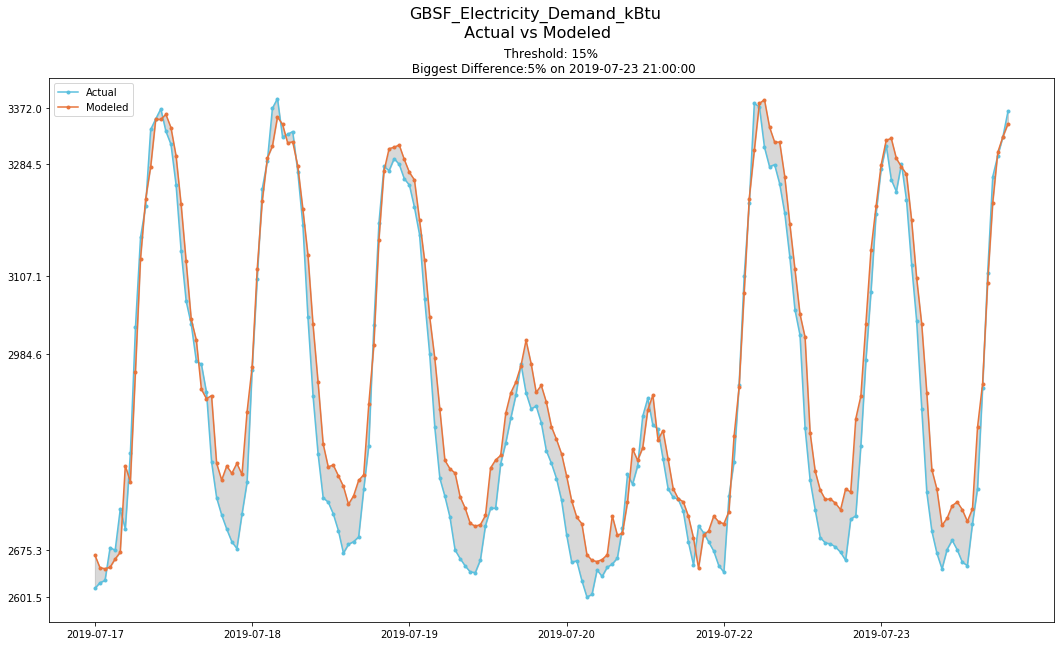

In [19]:
plt.figure(figsize=(18,10))
count = 1
for ii in range(len(actual)):
    
    if difference[ii] > anomaly_threshold:
        if count%2 == 0:
            plt.text(idx[ii] , ymin*0.99, int(difference[ii]), size = 11)
            count = count +1
        else:
            plt.text(idx[ii] , ymin*1.00, int(difference[ii]), size = 11)
            count = count +1
        plt.axvline(x = idx[ii], color = 'r', linestyle = '--')
plt.plot(idx, actual, marker = ".", color="#5bc0de", label = 'Actual')
plt.plot(idx, modeled, marker = ".", color="#E8743B", label = "Modeled")

plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(idx, actual, modeled, color = "grey", alpha = "0.3")
plt.yticks(actual, size= 10)
plt.xticks(idx, size = 10)

plt.locator_params(axis = 'y', tight = True, nbins=6)
plt.locator_params(axis = 'x', nbins = 6)
biggest_difference = result.loc[result['Difference'] == max(difference)]['Difference'][0]
at_time = result.loc[result['Difference'] == max(difference)].index[0]
plt.suptitle(f"{point_name}\n Actual vs Modeled", fontsize = 16)
plt.title(f"Threshold: {anomaly_threshold}%\n Biggest Difference:{int(biggest_difference)}% on {at_time}")
plt.legend()
plt.show()